<a href="https://colab.research.google.com/github/DonnaVakalis/Urban.dat/blob/master/Toronto_FloorSpaceTrends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analyze Residential Floor Space Trends

 

## Table of Contents
- [Introduction](#intro)
- [Part I - ](#partone)
- [Part II - ](#parttwo)
- [Part III - ](#partthree)


<a id='intro'></a>
### Introduction
 


<a id='partone'></a>
### Part I - Setup

In [1]:
# import libraries

!pip install statsmodels

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from google.colab import drive
import statsmodels as sm

%matplotlib inline
 

In [2]:
# Mount Google Drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/")

Mounted at /content/gdrive


In [3]:
# Load csv files
base_dir =  "/content/gdrive/My Drive/Colab Notebooks/SSG/Toronto_2023/"

# all buildings
file = base_dir + "df_all_bldgs.csv"
df1 = pd.read_csv(file)

# floorspace
file = base_dir + "df_all_floorspace.csv"
df2= pd.read_csv(file) 

# units
file = base_dir + "df_all_units.csv"
df3 = pd.read_csv(file) 

In [31]:
# we can merge into one dataframe
df = pd.merge(df1, df2,  how='inner',  on=['ID_TAZ','buildingClass','yearbuiltClass'])
df = pd.merge(df, df3, how = 'inner', on = ['ID_TAZ','buildingClass','yearbuiltClass'])

In [5]:
df.tail(100)

,ID_TAZ,buildingClass,yearbuiltClass,numBldgs,floorSpc_sf,numUnits
16790,73,Apt_13AndUpStorey,2016,1.0,134022.000000,195.0
16791,73,Apt_1To3Storey,1951,3.0,3174.333333,13.0
16792,73,Apt_1To3Storey,1961,1.0,1948.000000,3.0
16793,73,Apt_1To3Storey,2016,1.0,3023.000000,2.0
16794,73,Apt_4To6Storey,1961,1.0,74400.000000,62.0
...,...,...,...,...,...,...
16885,98,Apt_7To12Storey,2016,1.0,61904.000000,87.0
16886,99,Apt_13AndUpStorey,1986,1.0,178800.000000,149.0
16887,99,Apt_1To3Storey,1951,16.0,4891.062500,86.0
16888,99,Apt_1To3Storey,1971,2.0,2573.000000,6.0


<a id='parttwo></a>
### Part II - Organizing data

In [6]:
# Do any of the rows have missing values?
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16890 entries, 0 to 16889
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID_TAZ          16890 non-null  int64  
 1   buildingClass   16890 non-null  object 
 2   yearbuiltClass  16890 non-null  int64  
 3   numBldgs        16890 non-null  float64
 4   floorSpc_sf     16890 non-null  float64
 5   numUnits        16890 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 923.7+ KB


We care about the average size of the unit over time for a given buildingClass...



In [32]:
# Drop TAZ column (not relevant)
df.drop('ID_TAZ',
  axis='columns', inplace=True)

# Create a floorSpcPerUnit_sf (floorspace for a dwelling unit)
df['floorSpcPerUnit_sf'] = df['floorSpc_sf']/df['numUnits']


#Groupby Building Class and Year, get averages for floorspace per unit
grouped_df = df.groupby(['buildingClass', 'yearbuiltClass']).mean().reset_index()

# Assign proportion of total floor space
#grouped_df['propF']

grouped_df.head(300)

,buildingClass,yearbuiltClass,numBldgs,floorSpc_sf,numUnits,floorSpcPerUnit_sf
0,Apt_13AndUpStorey,1956,1.000000,326400.000000,272.000000,1200.000000
1,Apt_13AndUpStorey,1961,1.360000,254616.000000,285.640000,1080.000000
2,Apt_13AndUpStorey,1966,1.763158,322876.073308,464.789474,913.111346
3,Apt_13AndUpStorey,1971,2.063636,321431.379437,567.700000,804.312831
4,Apt_13AndUpStorey,1976,2.159091,372630.545793,640.250000,780.716128
...,...,...,...,...,...,...
148,Single_detached_small,1996,7.436508,1798.657238,7.436508,1049.069738
149,Single_detached_small,2001,14.000000,1863.731893,14.000000,884.287250
150,Single_detached_small,2006,17.053571,1901.729893,17.053571,956.678455
151,Single_detached_small,2011,6.768293,2006.256102,6.768293,994.660212


In [11]:
# How many building classes are there?
grouped_df['buildingClass'].unique()

array(['Apt_13AndUpStorey', 'Apt_1To3Storey', 'Apt_4To6Storey',
       'Apt_7To12Storey', 'Double_detached_large',
       'Double_detached_small', 'Row_house_large', 'Row_house_small',
       'Single_detached_large', 'Single_detached_medium',
       'Single_detached_small'], dtype=object)

In [46]:
# table with number of units built for each building typology
# use the grouped_df, and sum the number of units by building class and year...

#eg df.groupby(['A','C'])['B'].sum()

counts_long = grouped_df.groupby(['yearbuiltClass','buildingClass'])['numUnits'].sum().reset_index()
 

counts_long

,yearbuiltClass,buildingClass,numUnits
0,1951,Apt_1To3Storey,91.054945
1,1951,Apt_4To6Storey,99.937500
2,1951,Apt_7To12Storey,102.681818
3,1951,Double_detached_large,225.691589
4,1951,Double_detached_small,36.103448
...,...,...,...
148,2016,Row_house_large,19.000000
149,2016,Row_house_small,89.048544
150,2016,Single_detached_large,12.711628
151,2016,Single_detached_medium,8.280335


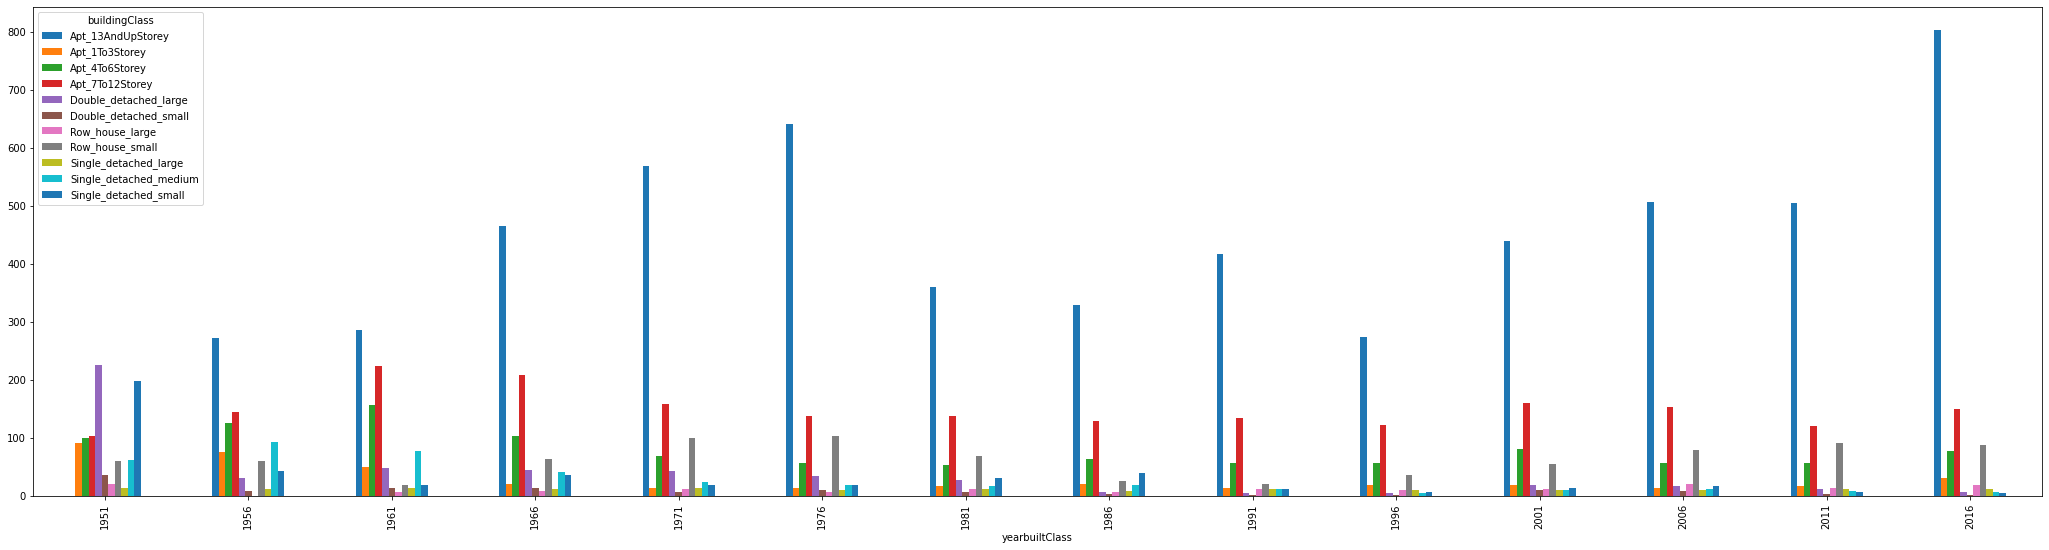

In [56]:
# then make a long df into a wide df by making the column names from the year

counts_wide = counts_long.pivot_table(index='yearbuiltClass', 
                    columns='buildingClass', 
                    values='numUnits').round()

counts_wide
#plt.figure(figsize=(50,3))
plt.rcParams["figure.figsize"] = [36,9]
ax = counts_wide.plot(kind='bar')
plt.show()

In [12]:
 # Plot each bulding class's floorSpacePerUnit across the years 
grouped_df['yearbuiltClass'] = pd.to_datetime(grouped_df['yearbuiltClass'].astype(str), format="%Y") #format year to datetime object

In [25]:
# overall weighted average each year 
# for each year, what is average floorSpcPerUnit ? (total floorspace divided by total numUnits)
overall = df[['buildingClass','yearbuiltClass','floorSpc_sf','numUnits']].groupby('yearbuiltClass').sum()
overall['averageFloorSpc_sf'] = overall['floorSpc_sf']/overall['numUnits']

# weighted average by Building Class each year
overall.reset_index(inplace=True)

<a id='partthree'></a>
### Part III - Plots

<Figure size 432x288 with 0 Axes>

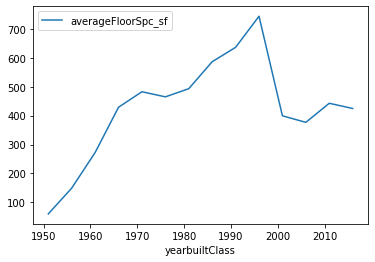

In [27]:
# plot weighted average
plt.figure()
data = overall
ax = data.plot(x='yearbuiltClass',y='averageFloorSpc_sf')
plt.show();

In [14]:
 # create separate dataframes called dwelling[i] 
dwelling = {i: x for i, (_, x) in enumerate(grouped_df.groupby('buildingClass'), 0)}

<Figure size 432x288 with 0 Axes>

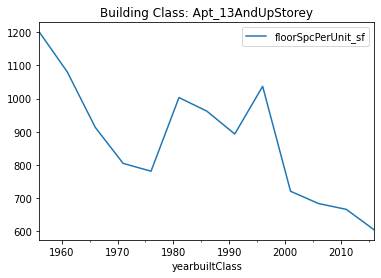

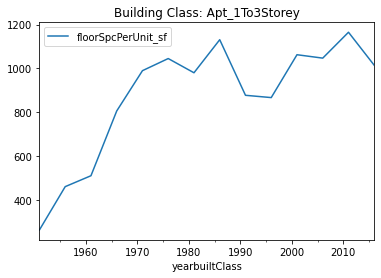

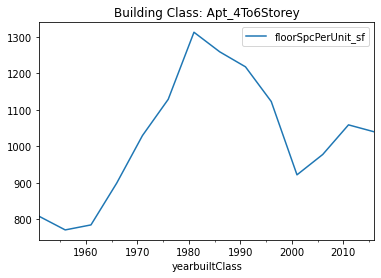

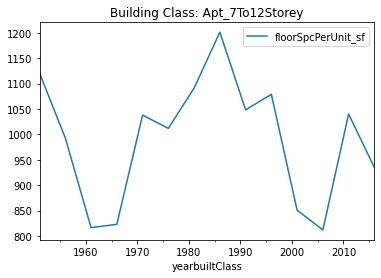

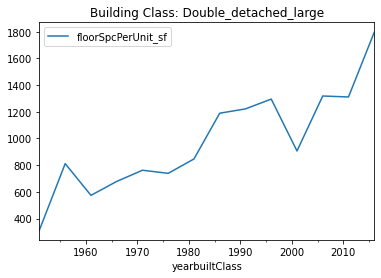

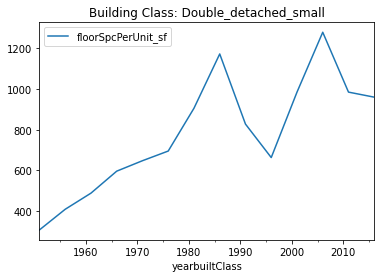

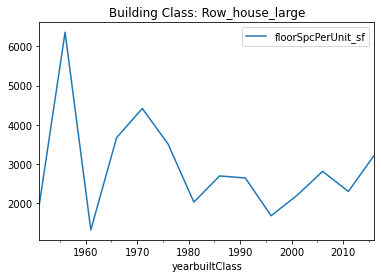

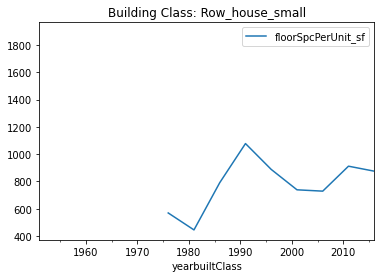

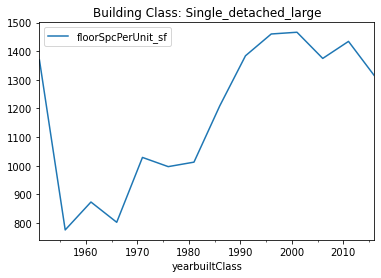

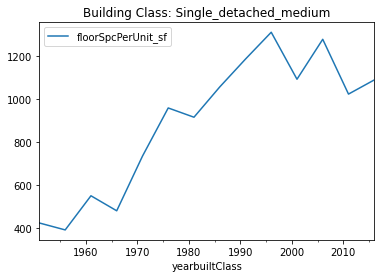

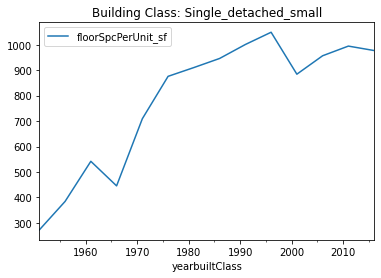

In [15]:
# plot each dwelling over time
plt.figure()
for i in range(len(dwelling)):
  data = dwelling[i] 
  name = data.buildingClass.iloc[0]
  ax = data.plot(x='yearbuiltClass',y='floorSpcPerUnit_sf')
  ax.set_title('Building Class: {}'.format(name));
plt.show();
    

In [ ]:
# plot Apartments of 4 stories and higher together